# Auto ROI

## TODO
### 1. image+mask
### 2. model train
### 3. connect pipeline

pip install labelme

labelme

### json -> mask(jpg)

In [20]:
import os
import json
import numpy as np
from PIL import Image

from labelme.utils import shapes_to_label

ANNOT_DIR = "annotations"
MASK_DIR = "masks"

os.makedirs(MASK_DIR, exist_ok=True)

for fn in os.listdir(ANNOT_DIR):
    if not fn.endswith(".json"):
        continue

    json_path = os.path.join(ANNOT_DIR, fn)
    stem = fn[:-5]  # remove .json

    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # labelme JSON에서 이미지 크기 얻기 (imageHeight/imageWidth가 보통 들어있음)
    h = data.get("imageHeight")
    w = data.get("imageWidth")
    if h is None or w is None:
        raise ValueError(f"{fn}: imageHeight/imageWidth가 JSON에 없습니다. labelme로 저장한 파일이 맞는지 확인하세요.")

    shapes = data["shapes"]

    # 클래스 이름 → id 매핑 (background=0, surface=1)
    # surface 말고 다른 라벨이 섞여 있어도 전부 background로 취급하려면 surface만 남기고 나머지 제거
    filtered_shapes = [s for s in shapes if s.get("label") == "surface"]

    label_name_to_value = {"_background_": 0, "surface": 1}

    mask, _ = shapes_to_label(
    img_shape=(h, w, 3),
    shapes=filtered_shapes,
    label_name_to_value=label_name_to_value,
    )

    mask = mask.astype(np.uint8)

    out_path = os.path.join(MASK_DIR, stem + ".png")
    Image.fromarray(mask).save(out_path)

print("✅ JSON → mask(PNG) 생성 완료")

✅ JSON → mask(PNG) 생성 완료


In [21]:

import numpy as np
print(np.unique(np.array(Image.open("masks/001000.png"))))

[0 1]


### ROI comp

In [22]:
import os, glob, random
from PIL import Image
import cv2


def largest_component(binary_mask: np.ndarray) -> np.ndarray:
    # binary_mask: uint8 (0/255)
    num, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
    if num <= 1:
        return binary_mask * 0
    # 0은 배경, 1..num-1 중 가장 큰 것 선택
    areas = stats[1:, cv2.CC_STAT_AREA]
    idx = 1 + int(np.argmax(areas))
    return np.where(labels == idx, 255, 0).astype(np.uint8)

def refine_mask(binary_mask: np.ndarray) -> np.ndarray:
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    m = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, k, iterations=2)
    m = cv2.morphologyEx(m, cv2.MORPH_OPEN,  k, iterations=1)
    m = largest_component(m)
    return m

def shrink_rotated_rect(rect, margin_px: float):
    # rect = ((cx,cy),(w,h),angle)
    (cx, cy), (w, h), angle = rect
    w2 = max(1.0, w - 2.0 * margin_px)
    h2 = max(1.0, h - 2.0 * margin_px)
    return ((cx, cy), (w2, h2), angle)

def rect_to_boxpoints(rect):
    pts = cv2.boxPoints(rect)  # 4x2 float32
    return pts

def ema_smooth(prev, cur, alpha=0.7):
    # alpha 가까울수록 "이전"을 더 믿음 (흔들림 감소)
    if prev is None:
        return cur
    (pc, ps, pa) = prev
    (cc, cs, ca) = cur
    cx = alpha*pc[0] + (1-alpha)*cc[0]
    cy = alpha*pc[1] + (1-alpha)*cc[1]
    w  = alpha*ps[0] + (1-alpha)*cs[0]
    h  = alpha*ps[1] + (1-alpha)*cs[1]
    a  = alpha*pa     + (1-alpha)*ca
    return ((cx, cy), (w, h), a)

def roi_from_mask(sheet_mask_u8: np.ndarray, margin_px: float, prev_rect=None):
    # sheet_mask_u8: 0/255
    m = refine_mask(sheet_mask_u8)
    contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, m
    cnt = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(cnt)
    rect = shrink_rotated_rect(rect, margin_px)
    rect = ema_smooth(prev_rect, rect, alpha=0.7)
    return rect, m

# ROI Crop


In [23]:
def crop_rotated_rect(image, rect):
    (cx, cy), (w, h), angle = rect
    # 회전 행렬
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    rotated = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]),
                             flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    x = int(cx - w/2); y = int(cy - h/2)
    w = int(w); h = int(h)
    x = max(0, x); y = max(0, y)
    return rotated[y:y+h, x:x+w]

In [79]:

import torch
from torch.utils.data import Dataset, DataLoader

class SegDataset(Dataset):
    def __init__(self, frames_dir="frames", masks_dir="masks", target_w=896):
        self.frames = sorted(glob.glob(os.path.join(frames_dir, "*")))
        self.masks_dir = masks_dir
        self.target_w = target_w

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        img_path = self.frames[idx]
        stem = os.path.splitext(os.path.basename(img_path))[0]
        mask_path = os.path.join(self.masks_dir, stem + ".png")

        # image: BGR uint8 -> RGB float [0,1]
        bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if bgr is None:
            raise FileNotFoundError(img_path)
        h, w = bgr.shape[:2]
        scale = self.target_w / w
        nh = int(h * scale)

        bgr = cv2.resize(bgr, (self.target_w, nh), interpolation=cv2.INTER_AREA)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        x = torch.from_numpy(rgb).permute(2,0,1)  # 3xHxW

        # mask: uint8 (0/1 or 0/255) -> float 0/1
        m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if m is None:
            raise FileNotFoundError(mask_path)

        # 0/1 mask면 0/255로 스케일업 (안정화)
        if m.max() == 1:
            m = (m * 255).astype(np.uint8)

        # resize
        m = cv2.resize(m, (self.target_w, nh), interpolation=cv2.INTER_NEAREST)

        # binarize (항상 통일)
        m = (m > 127).astype(np.float32)

        # tensor
        y = torch.from_numpy(m).unsqueeze(0)  # 1xHxW

        return x, y
def pad_collate(batch):
    xs, ys = zip(*batch)  # xs: (3,H,W), ys: (1,H,W)

    max_h = max(x.shape[1] for x in xs)
    max_w = max(x.shape[2] for x in xs)

    xs_pad, ys_pad = [], []
    for x, y in zip(xs, ys):
        dh = max_h - x.shape[1]
        dw = max_w - x.shape[2]
        xs_pad.append(F.pad(x, (0, dw, 0, dh), value=0.0))
        ys_pad.append(F.pad(y, (0, dw, 0, dh), value=0.0))

    return torch.stack(xs_pad, 0), torch.stack(ys_pad, 0)

train_ds = SegDataset("frames", "masks", target_w=896)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0, pin_memory=False, collate_fn=pad_collate)
print("num samples:", len(train_ds))

num samples: 57


In [80]:
_, y = train_ds[0]
print("y unique:", torch.unique(y), "y sum:", y.sum().item())

y unique: tensor([0., 1.]) y sum: 8714.0


In [81]:
cnt = 0
for i in range(len(train_ds)):
    _, y = train_ds[i]
    if y.sum() > 0:
        cnt += 1
print("foreground samples:", cnt, "/", len(train_ds))

foreground samples: 57 / 57


In [83]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import cv2
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)


cuda


In [84]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import functional as TF
from tqdm import tqdm
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

#### model

##### input: (B,3,H,W)  output: 1ch, (B,1,H,W)  Loss: BCE with logits loss  sigmoid -> thresh=0.5

In [85]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

In [86]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, base=32):
        super().__init__()
        self.d1 = DoubleConv(in_channels, base)
        self.p1 = nn.MaxPool2d(2)

        self.d2 = DoubleConv(base, base*2)
        self.p2 = nn.MaxPool2d(2)

        self.d3 = DoubleConv(base*2, base*4)
        self.p3 = nn.MaxPool2d(2)

        self.b = DoubleConv(base*4, base*8)

        self.u3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.c3 = DoubleConv(base*8, base*4)

        self.u2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.c2 = DoubleConv(base*4, base*2)

        self.u1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.c1 = DoubleConv(base*2, base)

        self.out = nn.Conv2d(base, out_channels, 1)

    def forward(self, x):
        d1 = self.d1(x); p1 = self.p1(d1)
        d2 = self.d2(p1); p2 = self.p2(d2)
        d3 = self.d3(p2); p3 = self.p3(d3)
        b  = self.b(p3)

        u3 = self.u3(b)
        u3 = torch.cat([u3, d3], dim=1)
        u3 = self.c3(u3)

        u2 = self.u2(u3)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.c2(u2)

        u1 = self.u1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.c1(u1)

        return self.out(u1)  # logits (B,1,H,W)

In [87]:

model = UNet(in_channels=3, out_channels=1, base=32).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 20


In [88]:

model.train()

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")

    for x, y in pbar:
        # 1) device 이동
        x = x.to(device, non_blocking=True)  # (B,3,H,W)
        y = y.to(device, non_blocking=True)  # (B,1,H,W) float 0/1

        # 2) forward
        logits = model(x)  # (B,1,H,W) 여야 함

        # 3) loss
        loss = criterion(logits, y)

        # 4) backward
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch}: avg_loss={avg_loss:.4f}")


Epoch 1/20: 100%|██████████| 29/29 [00:04<00:00,  6.82it/s, loss=0.297]


Epoch 1: avg_loss=0.3961


Epoch 2/20: 100%|██████████| 29/29 [00:03<00:00,  7.33it/s, loss=0.219]


Epoch 2: avg_loss=0.2526


Epoch 3/20: 100%|██████████| 29/29 [00:04<00:00,  6.71it/s, loss=0.157]


Epoch 3: avg_loss=0.1825


Epoch 4/20: 100%|██████████| 29/29 [00:04<00:00,  6.83it/s, loss=0.112]


Epoch 4: avg_loss=0.1361


Epoch 5/20: 100%|██████████| 29/29 [00:04<00:00,  6.77it/s, loss=0.0872]


Epoch 5: avg_loss=0.1008


Epoch 6/20: 100%|██████████| 29/29 [00:04<00:00,  6.64it/s, loss=0.0675]


Epoch 6: avg_loss=0.0764


Epoch 7/20: 100%|██████████| 29/29 [00:04<00:00,  6.78it/s, loss=0.0534]


Epoch 7: avg_loss=0.0612


Epoch 8/20: 100%|██████████| 29/29 [00:04<00:00,  6.89it/s, loss=0.0448]


Epoch 8: avg_loss=0.0492


Epoch 9/20: 100%|██████████| 29/29 [00:04<00:00,  6.83it/s, loss=0.0355]


Epoch 9: avg_loss=0.0399


Epoch 10/20: 100%|██████████| 29/29 [00:04<00:00,  6.92it/s, loss=0.0313]


Epoch 10: avg_loss=0.0335


Epoch 11/20: 100%|██████████| 29/29 [00:04<00:00,  6.90it/s, loss=0.026] 


Epoch 11: avg_loss=0.0284


Epoch 12/20: 100%|██████████| 29/29 [00:04<00:00,  6.84it/s, loss=0.0227]


Epoch 12: avg_loss=0.0255


Epoch 13/20: 100%|██████████| 29/29 [00:04<00:00,  6.78it/s, loss=0.0195]


Epoch 13: avg_loss=0.0223


Epoch 14/20: 100%|██████████| 29/29 [00:04<00:00,  6.74it/s, loss=0.0175]


Epoch 14: avg_loss=0.0201


Epoch 15/20: 100%|██████████| 29/29 [00:04<00:00,  6.84it/s, loss=0.0279]


Epoch 15: avg_loss=0.0228


Epoch 16/20: 100%|██████████| 29/29 [00:04<00:00,  6.77it/s, loss=0.0189]


Epoch 16: avg_loss=0.0206


Epoch 17/20: 100%|██████████| 29/29 [00:04<00:00,  6.65it/s, loss=0.0131]


Epoch 17: avg_loss=0.0163


Epoch 18/20: 100%|██████████| 29/29 [00:04<00:00,  6.71it/s, loss=0.0123]


Epoch 18: avg_loss=0.0149


Epoch 19/20: 100%|██████████| 29/29 [00:04<00:00,  6.69it/s, loss=0.0116]


Epoch 19: avg_loss=0.0133


Epoch 20/20: 100%|██████████| 29/29 [00:04<00:00,  6.73it/s, loss=0.00973]


Epoch 20: avg_loss=0.0123


In [89]:

torch.save(model.state_dict(), "roi_seg_model_state.pt")
print("saved: roi_seg_model_state.pt")

saved: roi_seg_model_state.pt


# pytorch Segmentation

In [90]:
model = UNet(in_channels=3, out_channels=1, base=32).to(device)
model.load_state_dict(torch.load("roi_seg_model_state.pt", map_location=device))
model.eval()

UNet(
  (d1): DoubleConv(
    (net): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (p1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (d2): DoubleConv(
    (net): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [115]:
def preprocess_bgr(frame_bgr, target_w=896):
    h, w = frame_bgr.shape[:2]
    scale = target_w / w
    nh = int(h * scale)

    small = cv2.resize(frame_bgr, (target_w, nh), interpolation=cv2.INTER_AREA)

    rgb = cv2.cvtColor(small, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    x = torch.from_numpy(rgb).permute(2,0,1).unsqueeze(0)  # 1x3xHxW
    return x, scale, small

@torch.no_grad()
def infer_sheet_mask(frame_bgr, target_w=896, thresh=0.5):
    x, scale, small = preprocess_bgr(frame_bgr, target_w)
    x = x.to(device)

    logits = model(x)                         # (1,1,H,W)
    prob = torch.sigmoid(logits)[0,0].cpu().numpy()
    m = (prob > thresh).astype(np.uint8) * 255  # 0/255
    return m, prob, scale, small

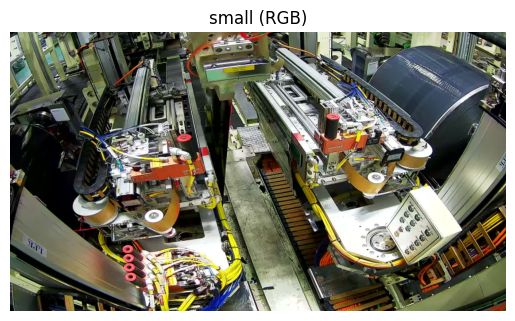

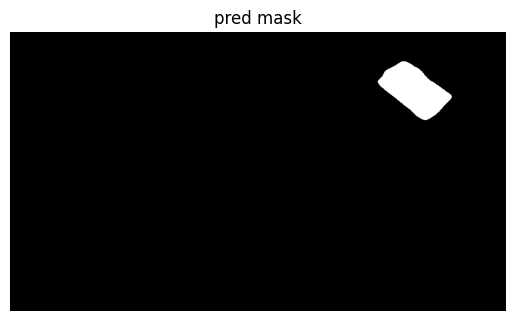

In [116]:
import matplotlib.pyplot as plt

frame_path = train_ds.pairs[0][0] if hasattr(train_ds, "pairs") else train_ds.frames[0]
frame_bgr = cv2.imread(frame_path)

m, prob,scale, small = infer_sheet_mask(frame_bgr, target_w=896, thresh=0.5)

plt.figure()
plt.title("small (RGB)")
plt.imshow(cv2.cvtColor(small, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.figure()
plt.title("pred mask")
plt.imshow(m, cmap="gray")
plt.axis("off")
plt.show()

In [117]:
# def roi_from_mask(mask_u8, min_area=2000):
#     # mask_u8: 0/255
#     cnts, _ = cv2.findContours(mask_u8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     if not cnts:
#         return None
#     c = max(cnts, key=cv2.contourArea)
#     if cv2.contourArea(c) < min_area:
#         return None
#     rect = cv2.minAreaRect(c)  # ((cx,cy),(w,h),angle)
#     return rect

#안정화 버전. morphology 추가 - 추론 +마스크 만들기(unet binary)
def roi_from_mask(mask_u8, min_area=2000):
    if mask_u8 is None:
        return None

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    mm = cv2.morphologyEx(mask_u8, cv2.MORPH_OPEN, k, iterations=1)
    mm = cv2.morphologyEx(mm, cv2.MORPH_CLOSE, k, iterations=2)

    cnts, _ = cv2.findContours(mm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None

    c = max(cnts, key=cv2.contourArea)
    if cv2.contourArea(c) < min_area:
        return None

    rect = cv2.minAreaRect(c)
    return rect

rect = roi_from_mask(m, min_area=2000)
print("rect:", rect)

rect: ((729.8909301757812, 103.56990051269531), (123.52865600585938, 68.65888977050781), 38.904136657714844)


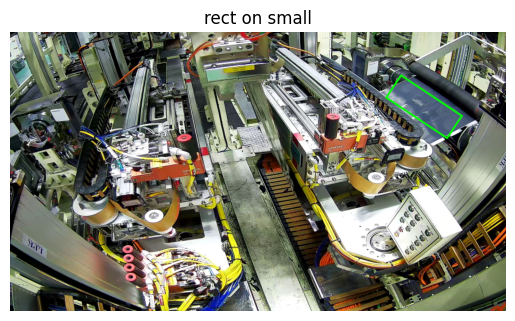

In [153]:
def draw_rect(img_bgr, rect, color=(0,255,0), thickness=2):
    box = cv2.boxPoints(rect).astype(np.int32)
    out = img_bgr.copy()
    cv2.drawContours(out, [box], 0, color, thickness)
    return out

def shrink_rect(rect, shrink=0.9):
    (cx, cy), (w, h), angle = rect
    return ((cx, cy), (w*shrink, h*shrink), angle)

if rect is not None:
    vis = draw_rect(small, rect)
    plt.figure()
    plt.title("rect on small")
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [142]:
def crop_rotated_rect(img_bgr, rect, out_w=320, out_h=320, shrink=0.9):
    (cx, cy), (w, h), angle = rect

    # 1) 각도 뒤집힘 보정 (핵심)
    if w < h:
        w, h = h, w
        angle = angle + 90.0

    w = w * shrink
    h = h * shrink
    
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    rotated = cv2.warpAffine(img_bgr, M,
                             (img_bgr.shape[1], img_bgr.shape[0]),
                             flags=cv2.INTER_LINEAR)

    # 2) 안전한 crop (좌표 클리핑)
    x0 = int(cx - w/2); y0 = int(cy - h/2)
    x1 = int(cx + w/2); y1 = int(cy + h/2)

    x0 = max(0, x0); y0 = max(0, y0)
    x1 = min(rotated.shape[1], x1)
    y1 = min(rotated.shape[0], y1)

    crop = rotated[y0:y1, x0:x1]
    if crop.size == 0:
        return None

    # 3) 크기 고정 (검사용)
    crop = cv2.resize(crop, (out_w, out_h), interpolation=cv2.INTER_AREA)
    return crop

## probability chceck

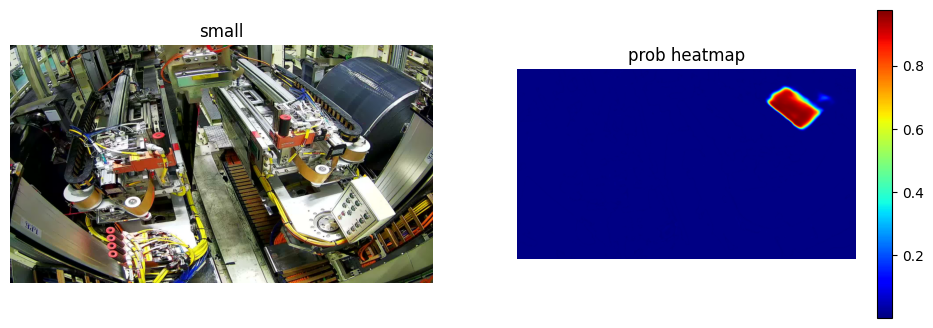

prob min/max: 0.0017898465 0.97707796


In [96]:
@torch.no_grad()
def infer_prob(frame_bgr, target_w=896):
    x, scale, small = preprocess_bgr(frame_bgr, target_w)
    x = x.to(device)
    logits = model(x)
    prob = torch.sigmoid(logits)[0,0].cpu().numpy()
    return prob, small

prob, small = infer_prob(frame_bgr)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("small")
plt.imshow(cv2.cvtColor(small, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,2,2)
plt.title("prob heatmap")
plt.imshow(prob, cmap="jet")
plt.colorbar()
plt.axis("off")
plt.show()

print("prob min/max:", prob.min(), prob.max())

In [65]:
img_path = train_ds.frames[0]
stem = os.path.splitext(os.path.basename(img_path))[0]
mask_path = os.path.join("masks", stem + ".png")

gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
fg_ratio = (gt > 127).mean()
print("foreground ratio:", fg_ratio)
print("mask unique:", np.unique(gt))
print("max:", gt.max(), "min:", gt.min())

foreground ratio: 0.0
mask unique: [0 1]
max: 1 min: 0


In [98]:
fg_pixels = int((gt > 0).sum())
total_pixels = gt.size
print("fg_pixels:", fg_pixels, "total:", total_pixels, "ratio:", fg_pixels/total_pixels)


fg_pixels: 8714 total: 451584 ratio: 0.01929652069160998


In [104]:
fg_pixels = int((gt > 0).sum())
total_pixels = gt.size
print("fg_pixels:", fg_pixels, "total:", total_pixels, "ratio:", fg_pixels/total_pixels)

fg_pixels: 8714 total: 451584 ratio: 0.01929652069160998


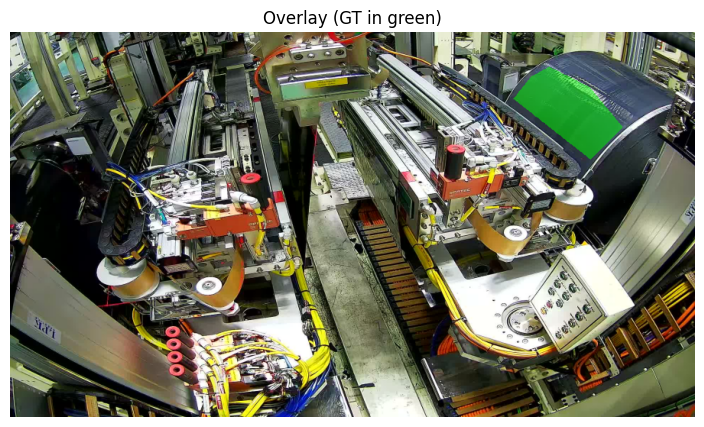

gt_s unique: [0 1] fg_pixels: 8714


In [105]:
img = cv2.imread(img_path)
gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

h, w = img.shape[:2]
scale = 896 / w
nh = int(h * scale)

img_s = cv2.resize(img, (896, nh), interpolation=cv2.INTER_AREA)
gt_s  = cv2.resize(gt,  (896, nh), interpolation=cv2.INTER_NEAREST)

overlay = img_s.copy()
overlay[gt_s > 0] = (0.5 * overlay[gt_s > 0] + 0.5 * np.array([0, 255, 0])).astype(np.uint8)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Overlay (GT in green)")
plt.axis("off")
plt.show()

print("gt_s unique:", np.unique(gt_s), "fg_pixels:", int((gt_s>0).sum()))

### overfitting test

In [82]:
# ====== 0. imports ======
import os, cv2, numpy as np, torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# ====== 1. Dataset sanity check ======
print("CWD:", os.getcwd())
print("Dataset masks_dir:", train_ds.masks_dir)

# 첫 샘플 마스크 확인
x_chk, y_chk = train_ds[0]
print("train_ds[0] y sum:", y_chk.sum().item(), 
      "unique:", torch.unique(y_chk))

if y_chk.sum() == 0:
    print("⚠️ 첫 샘플은 foreground 없음 (정상일 수 있음)")

# ====== 2. foreground 있는 샘플 자동 탐색 ======
idx = None
for i in range(len(train_ds)):
    _, y = train_ds[i]
    if y.sum() > 0:
        idx = i
        break

if idx is None:
    raise RuntimeError("❌ Dataset에서 foreground 있는 샘플을 하나도 못 찾음")

print("✅ using foreground sample idx:", idx)

# ====== 3. overfit용 샘플 준비 ======
x0, y0 = train_ds[idx]
x0 = x0.unsqueeze(0).to(device)   # (1,3,H,W)
y0 = y0.unsqueeze(0).to(device)   # (1,1,H,W)

# foreground ratio / pos_weight
p = float(y0.mean().item())
pos_w = (1.0 - p) / (p + 1e-6)

print(f"foreground ratio p={p:.6f}")
print(f"pos_weight={pos_w:.2f}")

# ====== 4. 모델 / loss / optimizer ======
model = UNet(in_channels=3, out_channels=1, base=32).to(device)

criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([pos_w], device=device)
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ====== 5. 1장 overfit ======
print("\n--- Overfit start ---")
for step in range(1, 401):
    model.train()
    logits = model(x0)
    loss = criterion(logits, y0)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if step % 50 == 0:
        with torch.no_grad():
            prob = torch.sigmoid(logits)[0, 0].cpu().numpy()
            pred = (prob > 0.5).astype(np.uint8)
            gt = (y0[0, 0].cpu().numpy() > 0.5).astype(np.uint8)

            inter = (pred & gt).sum()
            denom = pred.sum() + gt.sum()
            dice = (2 * inter / (denom + 1e-7)) if denom > 0 else 0.0

        print(f"step {step:3d} | loss {loss.item():.4f} "
              f"| prob_max {prob.max():.3f} | dice@0.5 {dice:.3f}")

print("--- Overfit done ---")

device: cuda
CWD: c:\Users\leeso\OneDrive\바탕 화면\Junyoung\cctv_insp
Dataset masks_dir: masks
train_ds[0] y sum: 8714.0 unique: tensor([0., 1.])
✅ using foreground sample idx: 0
foreground ratio p=0.019297
pos_weight=50.82

--- Overfit start ---
step  50 | loss 0.3213 | prob_max 1.000 | dice@0.5 0.940
step 100 | loss 0.1910 | prob_max 1.000 | dice@0.5 0.946
step 150 | loss 0.1139 | prob_max 1.000 | dice@0.5 0.978
step 200 | loss 0.0786 | prob_max 1.000 | dice@0.5 0.956
step 250 | loss 0.0500 | prob_max 1.000 | dice@0.5 0.986
step 300 | loss 0.0357 | prob_max 1.000 | dice@0.5 0.990
step 350 | loss 0.2297 | prob_max 1.000 | dice@0.5 0.769
step 400 | loss 0.0271 | prob_max 1.000 | dice@0.5 0.960
--- Overfit done ---


In [78]:
import os, cv2, numpy as np, torch

# 비교할 인덱스 (0으로 시작)
i = 0

# 1) dataset이 보는 경로로 raw mask 읽기
img_path = train_ds.frames[i]
stem = os.path.splitext(os.path.basename(img_path))[0]
mask_path = os.path.join(train_ds.masks_dir, stem + ".png")

m_raw = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
print("img_path:", img_path)
print("mask_path:", mask_path)
print("raw mask read None?", m_raw is None)
if m_raw is not None:
    print("raw unique:", np.unique(m_raw)[:10], "raw sum:", int(m_raw.sum()), "raw max:", int(m_raw.max()))

# 2) dataset 출력 확인
x_ds, y_ds = train_ds[i]
print("dataset y unique:", torch.unique(y_ds), "y sum:", float(y_ds.sum()))

# 3) dataset 내부 로직을 여기서 '동일하게' 재현해서 어디서 0되는지 확인
if m_raw is not None:
    # 이미지에서 nh 계산 (dataset과 같은 방식)
    bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    h, w = bgr.shape[:2]
    scale = train_ds.target_w / w
    nh = int(h * scale)

    m_rs = cv2.resize(m_raw, (train_ds.target_w, nh), interpolation=cv2.INTER_NEAREST)
    print("after resize unique:", np.unique(m_rs)[:10], "sum:", int(m_rs.sum()), "max:", int(m_rs.max()))

    # dataset의 이진화 로직 그대로
    if m_rs.max() > 1:
        m_bin = (m_rs > 127).astype(np.float32)
    else:
        m_bin = m_rs.astype(np.float32)

    print("after bin unique:", np.unique(m_bin)[:10], "sum:", float(m_bin.sum()), "max:", float(m_bin.max()))

img_path: frames\000127.jpg
mask_path: masks\000127.png
raw mask read None? False
raw unique: [0 1] raw sum: 40035 raw max: 1
dataset y unique: tensor([0.]) y sum: 0.0
after resize unique: [0 1] sum: 8714 max: 1
after bin unique: [0. 1.] sum: 8714.0 max: 1.0


## model load

In [108]:
print(os.getcwd())

c:\Users\leeso\OneDrive\바탕 화면\Junyoung\cctv_insp


In [109]:
model = UNet(in_channels=3, out_channels=1, base=32).to(device)
model.load_state_dict(torch.load("roi_seg_model_state.pt", map_location=device))
model.eval()

UNet(
  (d1): DoubleConv(
    (net): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (p1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (d2): DoubleConv(
    (net): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

### ROI 안정화( 흔들림 감소)

In [120]:
class RectEMA:
    def __init__(self, alpha=0.2):
        self.alpha = alpha
        self.state = None  # np.array([cx,cy,w,h,angle])

    def update(self, rect):
        (cx, cy), (w, h), angle = rect
        x = np.array([cx, cy, w, h, angle], dtype=np.float32)

        if self.state is None:
            self.state = x
        else:
            self.state = (1 - self.alpha) * self.state + self.alpha * x

        cx, cy, w, h, angle = self.state.tolist()
        return ((cx, cy), (w, h), angle)

ema = RectEMA(alpha=0.2)

rect: ((729.8909301757812, 103.56990051269531), (123.52865600585938, 68.65888977050781), 38.904136657714844)


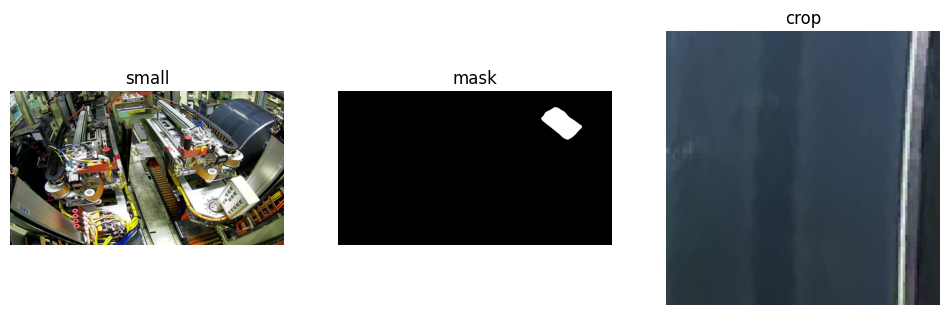

In [143]:
test_path = train_ds.frames[0]
frame_bgr = cv2.imread(test_path)

m, prob, scale, small = infer_sheet_mask(frame_bgr, target_w=896, thresh=0.5)
rect = roi_from_mask(m, min_area=2000)

print("rect:", rect)

if rect is not None:
    rect_s = ema.update(rect)
    vis = draw_rect(small, rect_s)
    crop = crop_rotated_rect(small, rect_s, out_w=320, out_h=320)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title("small"); plt.imshow(cv2.cvtColor(small, cv2.COLOR_BGR2RGB)); plt.axis("off")
    plt.subplot(1,3,2); plt.title("mask");  plt.imshow(m, cmap="gray"); plt.axis("off")
    plt.subplot(1,3,3); plt.title("crop");  plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)); plt.axis("off")
    plt.show()
else:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.title("small"); plt.imshow(cv2.cvtColor(small, cv2.COLOR_BGR2RGB)); plt.axis("off")
    plt.subplot(1,2,2); plt.title("mask");  plt.imshow(m, cmap="gray"); plt.axis("off")
    plt.show()

In [167]:
def hms_to_sec(h=0, m=0, s=0):
    return h*3600 + m*60 + s

video_path = r"./videos/yajong.mp4"

cap = cv2.VideoCapture(video_path)
#webcam용
# cap = cv2.VideoCapture(0)

if not cap.isOpened():
    raise RuntimeError(f"Cannot open video: {video_path}")

In [168]:
start_sec = hms_to_sec(9, 35, 00)   # 2:35:00
end_sec   = hms_to_sec(9, 50, 0)   # 2:45:00
#n frame마다 update
every_n = 3
cap.set(cv2.CAP_PROP_POS_MSEC, start_sec * 1000)

fps = cap.get(cv2.CAP_PROP_FPS)

shrink =0.8
print("fps:", fps)

fps: 29.992355762233096


In [169]:
ema = RectEMA(alpha=0.2)

frame_idx = 0
while True:
    ok, frame_bgr = cap.read()
    if not ok:
        break

    # current time in seconds
    cur_sec = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0
    if cur_sec >= end_sec:
        break
    if frame_idx % every_n == 0:
        m, prob, scale, small = infer_sheet_mask(frame_bgr, target_w=896, thresh=0.5)
        rect = roi_from_mask(m, min_area=2000)

        show = small.copy()
        crop = None

        if rect is not None:
            rect = ema.update(rect)
            rect_s = shrink_rect(rect, shrink=shrink)
            # show = draw_rect(show, rect)
            show = draw_rect(show, rect_s)
            crop = crop_rotated_rect(small, rect, out_w=320, out_h=320, shrink=shrink)

        cv2.putText(show, f"t={cur_sec/3600:.2f}h", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 2)

    cv2.imshow("small + ROI", show)
    cv2.imshow("mask", m)
    if crop is not None:
        cv2.imshow("ROI crop", crop)

    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()